In [1]:
import pandas as pd
import numpy as np
import time

import torch
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder



In [2]:
# visualization

from tqdm import notebook
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.pyplot as plt
%matplotlib inline



In [3]:
# tensorboard
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

import gc


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())
torch.manual_seed(777)

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


In [5]:
from matplotlib import pyplot as plt
def print_image(img) :
    plt.imshow(img)
    plt.show()

In [6]:
def clear_gpu() :
    torch.cuda.empty_cache()
    gc.collect()

In [7]:
X_train = np.load('../dataset/Augmenteddata/X_train.npy')
y_train = np.load('../dataset/Augmenteddata/y_train.npy')
X_test = np.load('../dataset/Augmenteddata/X_test.npy')
y_test = np.load('../dataset/Augmenteddata/y_test.npy')
X_train = X_train/255
X_test = X_test/255

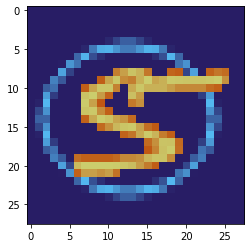

5
[0.20392157 0.28235294 0.54901961]


In [8]:
i = 10010
print_image(X_train[i])
print(y_train[i])
print(X_train[i,20,20,:])

In [9]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

345000
345000
15000
15000


In [10]:
X_train_tensor = torch.Tensor(X_train).reshape([-1,28,28,3]).to(device)
X_test_tensor = torch.Tensor(X_test).reshape([-1,28,28,3]).to(device)

y_train_tensor = torch.Tensor(y_train).to(device)
y_test_tensor = torch.Tensor(y_test).to(device)

In [11]:
from torch.utils.data import TensorDataset, DataLoader
train_ds = TensorDataset(X_train_tensor,y_train_tensor)
test_ds = TensorDataset(X_test_tensor,y_test_tensor) 

In [12]:
def conv_layer(chann_in, chann_out, k_size, p_size):
    layer = nn.Sequential(
        nn.Conv2d(chann_in, chann_out, kernel_size=k_size, padding=p_size),
        nn.BatchNorm2d(chann_out),
        nn.ReLU()
    )
    return layer

def vgg_conv_block(in_list, out_list, k_list, p_list, pooling_k, pooling_s):
    layers = [ conv_layer(in_list[i], out_list[i], k_list[i], p_list[i]) for i in range(len(in_list)) ]
    layers += [ nn.MaxPool2d(kernel_size = pooling_k, stride = pooling_s, ceil_mode=True)]
    return nn.Sequential(*layers)

def vgg_fc_layer(size_in, size_out, keep_prob, xavier=True):
    linear = nn.Linear(size_in, size_out)
    if xavier :
        torch.nn.init.xavier_uniform_(linear.weight)
    layer = nn.Sequential(
        linear,
        nn.BatchNorm1d(size_out),
        nn.ReLU(),
        nn.Dropout(p = 1 - keep_prob)
    )
    return layer



class MyModule(nn.Module):
    def __init__(self, keep_prob = 0.5, xavier = True):
        super(MyModule, self).__init__()
        # Conv blocks (BatchNorm + ReLU activation added in each block)
        channels = [32, 64, 128]

        self.layer1 = vgg_conv_block([3, channels[0]], [channels[0],channels[0]], [3,3], [0,0], 2, 2)
        self.layer2 = vgg_conv_block([channels[0],channels[1]], [channels[1],channels[1]], [3,3], [0,0], 2, 2)
        self.layer3 = vgg_conv_block([channels[1],channels[2]], [channels[2],channels[2]], [3,3], [1,0], 2, 2)

        # FC layers
        self.layer4 = vgg_fc_layer(channels[2], 1024, keep_prob = keep_prob,xavier = xavier)
        self.layer5 = vgg_fc_layer(1024, 800, keep_prob = keep_prob, xavier= xavier)

        # Final layer
        self.layer6 = nn.Linear(800, 10)

    def forward(self, x):
        x = x.permute(0,3,1,2)
        out = self.layer1(x)
        out = self.layer2(out)
        vgg16_features = self.layer3(out)
        out = vgg16_features.view(out.size(0), -1)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)

        return out


In [13]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'model_AUG/'+self.path)
        self.val_loss_min = val_loss


In [14]:
import tqdm

# model과 관련있는 함수들
def get_model(lr = 0.01, keep_prob = 0.5, xavier = True, weight_decay = 0.005):
    model = MyModule(keep_prob, xavier)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 4)
    return model.to(device), optimizer, scheduler
'''
opt 인자를 이용해 train과 valid의 동작을 다르게 해준다.
train : return [loss, learning_rate]
eval : return [loss]
'''
def loss_batch(model, loss_func, xb, yb, opt=None):
    out = []
    loss = loss_func(model(xb), yb)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        out.append(opt.param_groups[0]['lr'])
    out.append(loss.item())
    return out


def fit(epochs, model, loss_func, opt, scheduler, train_dl, valid_dl, path):
    start = time.time()
    train_loss = []
    valid_loss = []

    # earlystopping
    early_stopping = EarlyStopping(patience = 8, verbose = True, delta=0.0001, path = path+'_checkpoint.pt')

    # tqdm을 이용해 반복문 과정을 시각화 해준다.
    for epoch in tqdm.tqdm(range(epochs), desc = 'Epoch'):
        model.train()
        loss = []
        for xb, yb in tqdm.tqdm(train_dl, desc = 'train'):
            lr, l = loss_batch(model, loss_func, xb, yb, opt)
            loss.append(l)
        print("[Epoch: %d], train avg_loss: %f" % (epoch, (avg_loss := sum(loss)/len(loss))))
        train_loss.append(avg_loss)
        # train 결과물 write to tensorboard
        writer.add_scalar('{}/Loss/train'.format(path), avg_loss, epoch)
        writer.add_scalar('{}/learning_rate'.format(path), lr, epoch)

        model.eval()
        loss = []
        with torch.no_grad() :
            for xb, yb in tqdm.tqdm(valid_dl, desc = 'valid') :
                l = loss_batch(model, loss_func, xb, yb)[0]
                loss.append(l)
        print("[Epoch: %d], valid avg_loss: %f" % (epoch, (avg_loss := sum(loss)/len(loss))))
        valid_loss.append(avg_loss)
        # valid 결과물 write to tensorboard
        writer.add_scalar('{}/Loss/valid'.format(path), avg_loss, epoch)

        # scheduler 및 earlystopping
        scheduler.step(avg_loss)
        early_stopping(avg_loss, model)
        print('-'*50)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    print("cost time :", time.time() - start)      
    writer.flush()
    model.load_state_dict(torch.load('model_AUG/'+path+'_checkpoint.pt'))
    return model, train_loss, valid_loss


In [15]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

def preprocess(x, y):
    return x.to(device, dtype=torch.float), y.to(device, dtype=torch.long)


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))


In [107]:
# For Visualization

def accuracy(data):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in notebook.tqdm(data) :
            output = model(xb)
            pred = torch.argmax(output, dim = 1)
            correct += (pred == yb).sum()
            total += yb.size(0)
    print(correct, total)
    print("avg acc: %f" % (100* correct/total))  
    return correct / total * 100

def loss_graph(train_loss, valid_loss) :
    # 훈련이 진행되는 과정에 따라 loss를 시각화
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
    plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

    # validation loss의 최저값 지점을 찾기
    minposs = valid_loss.index(min(valid_loss))+1
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    fig.savefig('model'+path+'-loss_plot.png', bbox_inches = 'tight')

    print('lr : {}, keep_prob : {}, weight_decay : {}, layer : {}'.format(lr, keep_prob, weight_decay, layer))



In [108]:
# Cross entropy loss func
loss_func = nn.CrossEntropyLoss()

# hyper parameters
batch_size = 216
epochs = 500
lrs = [0.001, 0.0005]
keep_probs = [0.85, 0.9]
xavier = True
weight_decays = [0.005, 0.001, 0.0005]

# Dataset 정리
train_dl, valid_dl = get_data(train_ds, test_ds, batch_size)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)


In [18]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/3D_MNIST')


In [19]:
import gc
gc.collect()
torch.cuda.empty_cache()

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]/home/krex/anaconda3/envs/krex_3.9/lib/python3.9/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
train: 100%|██████████| 1598/1598 [00:33<00:00, 47.35it/s]


[Epoch: 0], train avg_loss: 0.251031


Epoch:   0%|          | 1/500 [00:34<4:43:31, 34.09s/it]

[Epoch: 0], valid avg_loss: 0.179626
Validation loss decreased (inf --> 0.179626).  Saving model ...
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 53.32it/s]


[Epoch: 1], train avg_loss: 0.131729


Epoch:   0%|          | 2/500 [01:04<4:24:38, 31.88s/it]

[Epoch: 1], valid avg_loss: 0.128852
Validation loss decreased (0.179626 --> 0.128852).  Saving model ...
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:30<00:00, 52.99it/s]


[Epoch: 2], train avg_loss: 0.119658


Epoch:   1%|          | 3/500 [01:34<4:19:00, 31.27s/it]

[Epoch: 2], valid avg_loss: 0.127595
Validation loss decreased (0.128852 --> 0.127595).  Saving model ...
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 53.45it/s]


[Epoch: 3], train avg_loss: 0.114501


Epoch:   1%|          | 4/500 [02:05<4:15:08, 30.86s/it]

[Epoch: 3], valid avg_loss: 0.145185
EarlyStopping counter: 1 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 53.94it/s]


[Epoch: 4], train avg_loss: 0.111255


Epoch:   1%|          | 5/500 [02:35<4:12:01, 30.55s/it]

[Epoch: 4], valid avg_loss: 0.100738
Validation loss decreased (0.127595 --> 0.100738).  Saving model ...
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 53.82it/s]


[Epoch: 5], train avg_loss: 0.110839


Epoch:   1%|          | 6/500 [03:05<4:10:06, 30.38s/it]

[Epoch: 5], valid avg_loss: 0.138153
EarlyStopping counter: 1 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 53.95it/s]


[Epoch: 6], train avg_loss: 0.109437


Epoch:   1%|▏         | 7/500 [03:35<4:08:28, 30.24s/it]

[Epoch: 6], valid avg_loss: 0.111225
EarlyStopping counter: 2 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:30<00:00, 52.81it/s]


[Epoch: 7], train avg_loss: 0.107394


Epoch:   2%|▏         | 8/500 [04:05<4:08:54, 30.35s/it]

[Epoch: 7], valid avg_loss: 0.120978
EarlyStopping counter: 3 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:30<00:00, 52.74it/s]


[Epoch: 8], train avg_loss: 0.108314


Epoch:   2%|▏         | 9/500 [04:36<4:09:08, 30.44s/it]

[Epoch: 8], valid avg_loss: 0.106650
EarlyStopping counter: 4 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 53.86it/s]


[Epoch: 9], train avg_loss: 0.106773


Epoch:   2%|▏         | 10/500 [05:06<4:07:34, 30.32s/it]

[Epoch: 9], valid avg_loss: 0.096026
Validation loss decreased (0.100738 --> 0.096026).  Saving model ...
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 53.91it/s]


[Epoch: 10], train avg_loss: 0.108060


Epoch:   2%|▏         | 11/500 [05:36<4:06:12, 30.21s/it]

[Epoch: 10], valid avg_loss: 0.107092
EarlyStopping counter: 1 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 53.62it/s]


[Epoch: 11], train avg_loss: 0.107284


Epoch:   2%|▏         | 12/500 [06:06<4:05:33, 30.19s/it]

[Epoch: 11], valid avg_loss: 0.133684
EarlyStopping counter: 2 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:30<00:00, 53.10it/s]


[Epoch: 12], train avg_loss: 0.106339


Epoch:   3%|▎         | 13/500 [06:37<4:06:00, 30.31s/it]

[Epoch: 12], valid avg_loss: 0.113104
EarlyStopping counter: 3 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 53.37it/s]


[Epoch: 13], train avg_loss: 0.105334


Epoch:   3%|▎         | 14/500 [07:07<4:05:27, 30.30s/it]

[Epoch: 13], valid avg_loss: 0.113606
EarlyStopping counter: 4 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 53.79it/s]


[Epoch: 14], train avg_loss: 0.105915


Epoch:   3%|▎         | 15/500 [07:37<4:04:22, 30.23s/it]

[Epoch: 14], valid avg_loss: 0.092607
Validation loss decreased (0.096026 --> 0.092607).  Saving model ...
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 53.77it/s]


[Epoch: 15], train avg_loss: 0.105996


Epoch:   3%|▎         | 16/500 [08:07<4:03:27, 30.18s/it]

[Epoch: 15], valid avg_loss: 0.134395
EarlyStopping counter: 1 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 53.51it/s]


[Epoch: 16], train avg_loss: 0.106683


Epoch:   3%|▎         | 17/500 [08:37<4:03:00, 30.19s/it]

[Epoch: 16], valid avg_loss: 0.099959
EarlyStopping counter: 2 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:30<00:00, 53.20it/s]


[Epoch: 17], train avg_loss: 0.106227


Epoch:   4%|▎         | 18/500 [09:08<4:03:01, 30.25s/it]

[Epoch: 17], valid avg_loss: 0.089586
Validation loss decreased (0.092607 --> 0.089586).  Saving model ...
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:30<00:00, 53.21it/s]


[Epoch: 18], train avg_loss: 0.105014


Epoch:   4%|▍         | 19/500 [09:38<4:02:48, 30.29s/it]

[Epoch: 18], valid avg_loss: 0.105858
EarlyStopping counter: 1 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:30<00:00, 53.16it/s]


[Epoch: 19], train avg_loss: 0.106561


Epoch:   4%|▍         | 20/500 [10:08<4:02:36, 30.33s/it]

[Epoch: 19], valid avg_loss: 0.120348
EarlyStopping counter: 2 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:30<00:00, 53.11it/s]


[Epoch: 20], train avg_loss: 0.106329


Epoch:   4%|▍         | 21/500 [10:39<4:02:21, 30.36s/it]

[Epoch: 20], valid avg_loss: 0.096233
EarlyStopping counter: 3 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 53.56it/s]


[Epoch: 21], train avg_loss: 0.106127


Epoch:   4%|▍         | 22/500 [11:09<4:01:25, 30.30s/it]

[Epoch: 21], valid avg_loss: 0.131560
EarlyStopping counter: 4 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 53.71it/s]


[Epoch: 22], train avg_loss: 0.105709


Epoch:   5%|▍         | 23/500 [11:39<4:00:23, 30.24s/it]

[Epoch: 22], valid avg_loss: 0.099716
EarlyStopping counter: 5 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 54.05it/s]


[Epoch: 23], train avg_loss: 0.061792


Epoch:   5%|▍         | 24/500 [12:09<3:59:08, 30.14s/it]

[Epoch: 23], valid avg_loss: 0.040590
Validation loss decreased (0.089586 --> 0.040590).  Saving model ...
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 53.51it/s]


[Epoch: 24], train avg_loss: 0.051302


Epoch:   5%|▌         | 25/500 [12:39<3:58:50, 30.17s/it]

[Epoch: 24], valid avg_loss: 0.035833
Validation loss decreased (0.040590 --> 0.035833).  Saving model ...
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 53.73it/s]


[Epoch: 25], train avg_loss: 0.046680


Epoch:   5%|▌         | 26/500 [13:09<3:58:11, 30.15s/it]

[Epoch: 25], valid avg_loss: 0.031676
Validation loss decreased (0.035833 --> 0.031676).  Saving model ...
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 54.49it/s]


[Epoch: 26], train avg_loss: 0.043673


Epoch:   5%|▌         | 27/500 [13:39<3:56:36, 30.01s/it]

[Epoch: 26], valid avg_loss: 0.031274
Validation loss decreased (0.031676 --> 0.031274).  Saving model ...
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 53.36it/s]


[Epoch: 27], train avg_loss: 0.042128


Epoch:   6%|▌         | 28/500 [14:09<3:56:49, 30.10s/it]

[Epoch: 27], valid avg_loss: 0.028268
Validation loss decreased (0.031274 --> 0.028268).  Saving model ...
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 53.61it/s]


[Epoch: 28], train avg_loss: 0.040375


Epoch:   6%|▌         | 29/500 [14:40<3:56:28, 30.12s/it]

[Epoch: 28], valid avg_loss: 0.025470
Validation loss decreased (0.028268 --> 0.025470).  Saving model ...
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:30<00:00, 53.16it/s]


[Epoch: 29], train avg_loss: 0.039575


Epoch:   6%|▌         | 30/500 [15:10<3:56:41, 30.22s/it]

[Epoch: 29], valid avg_loss: 0.023958
Validation loss decreased (0.025470 --> 0.023958).  Saving model ...
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 53.43it/s]


[Epoch: 30], train avg_loss: 0.038284


Epoch:   6%|▌         | 31/500 [15:40<3:56:16, 30.23s/it]

[Epoch: 30], valid avg_loss: 0.024156
EarlyStopping counter: 1 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:30<00:00, 52.73it/s]


[Epoch: 31], train avg_loss: 0.038037


Epoch:   6%|▋         | 32/500 [16:11<3:56:46, 30.36s/it]

[Epoch: 31], valid avg_loss: 0.024661
EarlyStopping counter: 2 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:30<00:00, 52.93it/s]


[Epoch: 32], train avg_loss: 0.037106


Epoch:   7%|▋         | 33/500 [16:42<3:56:42, 30.41s/it]

[Epoch: 32], valid avg_loss: 0.022371
Validation loss decreased (0.023958 --> 0.022371).  Saving model ...
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 54.02it/s]


[Epoch: 33], train avg_loss: 0.036672


Epoch:   7%|▋         | 34/500 [17:12<3:55:23, 30.31s/it]

[Epoch: 33], valid avg_loss: 0.021308
Validation loss decreased (0.022371 --> 0.021308).  Saving model ...
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 53.32it/s]


[Epoch: 34], train avg_loss: 0.036040


Epoch:   7%|▋         | 35/500 [17:42<3:54:54, 30.31s/it]

[Epoch: 34], valid avg_loss: 0.023276
EarlyStopping counter: 1 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 54.15it/s]


[Epoch: 35], train avg_loss: 0.036032


Epoch:   7%|▋         | 36/500 [18:12<3:53:21, 30.18s/it]

[Epoch: 35], valid avg_loss: 0.022691
EarlyStopping counter: 2 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:30<00:00, 52.90it/s]


[Epoch: 36], train avg_loss: 0.035167


Epoch:   7%|▋         | 37/500 [18:42<3:53:44, 30.29s/it]

[Epoch: 36], valid avg_loss: 0.021685
EarlyStopping counter: 3 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 53.56it/s]


[Epoch: 37], train avg_loss: 0.035962


Epoch:   8%|▊         | 38/500 [19:13<3:53:03, 30.27s/it]

[Epoch: 37], valid avg_loss: 0.021039
Validation loss decreased (0.021308 --> 0.021039).  Saving model ...
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 53.54it/s]


[Epoch: 38], train avg_loss: 0.034826


Epoch:   8%|▊         | 39/500 [19:43<3:52:21, 30.24s/it]

[Epoch: 38], valid avg_loss: 0.021030
EarlyStopping counter: 1 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 54.35it/s]


[Epoch: 39], train avg_loss: 0.035013


Epoch:   8%|▊         | 40/500 [20:12<3:50:43, 30.09s/it]

[Epoch: 39], valid avg_loss: 0.022222
EarlyStopping counter: 2 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 53.93it/s]


[Epoch: 40], train avg_loss: 0.035090


Epoch:   8%|▊         | 41/500 [20:42<3:49:57, 30.06s/it]

[Epoch: 40], valid avg_loss: 0.024143
EarlyStopping counter: 3 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:30<00:00, 52.80it/s]


[Epoch: 41], train avg_loss: 0.034684


Epoch:   8%|▊         | 42/500 [21:13<3:50:47, 30.24s/it]

[Epoch: 41], valid avg_loss: 0.021376
EarlyStopping counter: 4 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 53.32it/s]


[Epoch: 42], train avg_loss: 0.033908


Epoch:   9%|▊         | 43/500 [21:43<3:50:28, 30.26s/it]

[Epoch: 42], valid avg_loss: 0.022014
EarlyStopping counter: 5 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 53.52it/s]


[Epoch: 43], train avg_loss: 0.034974


Epoch:   9%|▉         | 44/500 [22:14<3:49:51, 30.24s/it]

[Epoch: 43], valid avg_loss: 0.023760
EarlyStopping counter: 6 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 53.60it/s]


[Epoch: 44], train avg_loss: 0.027372


Epoch:   9%|▉         | 45/500 [22:44<3:49:09, 30.22s/it]

[Epoch: 44], valid avg_loss: 0.016582
Validation loss decreased (0.021039 --> 0.016582).  Saving model ...
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 53.48it/s]


[Epoch: 45], train avg_loss: 0.024923


Epoch:   9%|▉         | 46/500 [23:14<3:48:41, 30.22s/it]

[Epoch: 45], valid avg_loss: 0.015481
Validation loss decreased (0.016582 --> 0.015481).  Saving model ...
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:30<00:00, 53.11it/s]


[Epoch: 46], train avg_loss: 0.024129


Epoch:   9%|▉         | 47/500 [23:44<3:48:41, 30.29s/it]

[Epoch: 46], valid avg_loss: 0.014352
Validation loss decreased (0.015481 --> 0.014352).  Saving model ...
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 53.85it/s]


[Epoch: 47], train avg_loss: 0.023360


Epoch:  10%|▉         | 48/500 [24:14<3:47:34, 30.21s/it]

[Epoch: 47], valid avg_loss: 0.014418
EarlyStopping counter: 1 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:30<00:00, 53.25it/s]


[Epoch: 48], train avg_loss: 0.023215


Epoch:  10%|▉         | 49/500 [24:45<3:47:26, 30.26s/it]

[Epoch: 48], valid avg_loss: 0.014101
Validation loss decreased (0.014352 --> 0.014101).  Saving model ...
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 53.75it/s]


[Epoch: 49], train avg_loss: 0.023242


Epoch:  10%|█         | 50/500 [25:15<3:46:35, 30.21s/it]

[Epoch: 49], valid avg_loss: 0.013814
Validation loss decreased (0.014101 --> 0.013814).  Saving model ...
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 53.94it/s]


[Epoch: 50], train avg_loss: 0.022745


Epoch:  10%|█         | 51/500 [25:45<3:45:50, 30.18s/it]

[Epoch: 50], valid avg_loss: 0.013760
EarlyStopping counter: 1 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 53.39it/s]


[Epoch: 51], train avg_loss: 0.022469


Epoch:  10%|█         | 52/500 [26:15<3:45:34, 30.21s/it]

[Epoch: 51], valid avg_loss: 0.013782
EarlyStopping counter: 2 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:30<00:00, 53.24it/s]


[Epoch: 52], train avg_loss: 0.022247


Epoch:  11%|█         | 53/500 [26:46<3:45:23, 30.25s/it]

[Epoch: 52], valid avg_loss: 0.013789
EarlyStopping counter: 3 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 53.63it/s]


[Epoch: 53], train avg_loss: 0.022181


Epoch:  11%|█         | 54/500 [27:16<3:44:39, 30.22s/it]

[Epoch: 53], valid avg_loss: 0.013650
Validation loss decreased (0.013814 --> 0.013650).  Saving model ...
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 53.30it/s]


[Epoch: 54], train avg_loss: 0.022050


Epoch:  11%|█         | 55/500 [27:46<3:44:25, 30.26s/it]

[Epoch: 54], valid avg_loss: 0.013336
Validation loss decreased (0.013650 --> 0.013336).  Saving model ...
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:30<00:00, 53.22it/s]


[Epoch: 55], train avg_loss: 0.021963


Epoch:  11%|█         | 56/500 [28:17<3:44:10, 30.29s/it]

[Epoch: 55], valid avg_loss: 0.013125
Validation loss decreased (0.013336 --> 0.013125).  Saving model ...
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:30<00:00, 53.18it/s]


[Epoch: 56], train avg_loss: 0.021954


Epoch:  11%|█▏        | 57/500 [28:47<3:43:53, 30.32s/it]

[Epoch: 56], valid avg_loss: 0.013065
EarlyStopping counter: 1 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:30<00:00, 52.75it/s]


[Epoch: 57], train avg_loss: 0.021837


Epoch:  12%|█▏        | 58/500 [29:18<3:44:03, 30.42s/it]

[Epoch: 57], valid avg_loss: 0.013137
EarlyStopping counter: 2 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:30<00:00, 53.07it/s]


[Epoch: 58], train avg_loss: 0.021969


Epoch:  12%|█▏        | 59/500 [29:48<3:43:36, 30.42s/it]

[Epoch: 58], valid avg_loss: 0.013066
EarlyStopping counter: 3 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:30<00:00, 53.02it/s]


[Epoch: 59], train avg_loss: 0.021755


Epoch:  12%|█▏        | 60/500 [30:19<3:43:15, 30.44s/it]

[Epoch: 59], valid avg_loss: 0.013730
EarlyStopping counter: 4 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 53.38it/s]


[Epoch: 60], train avg_loss: 0.021719


Epoch:  12%|█▏        | 61/500 [30:49<3:42:22, 30.39s/it]

[Epoch: 60], valid avg_loss: 0.013117
EarlyStopping counter: 5 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 53.90it/s]


[Epoch: 61], train avg_loss: 0.021554


Epoch:  12%|█▏        | 62/500 [31:19<3:40:59, 30.27s/it]

[Epoch: 61], valid avg_loss: 0.013206
EarlyStopping counter: 6 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:30<00:00, 53.04it/s]


[Epoch: 62], train avg_loss: 0.021204


Epoch:  13%|█▎        | 63/500 [31:49<3:40:56, 30.33s/it]

[Epoch: 62], valid avg_loss: 0.012812
Validation loss decreased (0.013125 --> 0.012812).  Saving model ...
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:30<00:00, 52.94it/s]


[Epoch: 63], train avg_loss: 0.021102


Epoch:  13%|█▎        | 64/500 [32:20<3:40:52, 30.40s/it]

[Epoch: 63], valid avg_loss: 0.012840
EarlyStopping counter: 1 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:30<00:00, 53.15it/s]


[Epoch: 64], train avg_loss: 0.021040


Epoch:  13%|█▎        | 65/500 [32:50<3:40:23, 30.40s/it]

[Epoch: 64], valid avg_loss: 0.012999
EarlyStopping counter: 2 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:30<00:00, 52.83it/s]


[Epoch: 65], train avg_loss: 0.020984


Epoch:  13%|█▎        | 66/500 [33:21<3:40:18, 30.46s/it]

[Epoch: 65], valid avg_loss: 0.013088
EarlyStopping counter: 3 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 54.08it/s]


[Epoch: 66], train avg_loss: 0.020974


Epoch:  13%|█▎        | 67/500 [33:51<3:38:34, 30.29s/it]

[Epoch: 66], valid avg_loss: 0.013195
EarlyStopping counter: 4 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 53.95it/s]


[Epoch: 67], train avg_loss: 0.020951


Epoch:  14%|█▎        | 68/500 [34:21<3:37:41, 30.24s/it]

[Epoch: 67], valid avg_loss: 0.012938
EarlyStopping counter: 5 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 54.02it/s]


[Epoch: 68], train avg_loss: 0.020892


Epoch:  14%|█▍        | 69/500 [34:51<3:36:32, 30.15s/it]

[Epoch: 68], valid avg_loss: 0.012879
EarlyStopping counter: 6 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 53.87it/s]


[Epoch: 69], train avg_loss: 0.020775


Epoch:  14%|█▍        | 70/500 [35:21<3:35:45, 30.11s/it]

[Epoch: 69], valid avg_loss: 0.013020
EarlyStopping counter: 7 out of 8
--------------------------------------------------


train: 100%|██████████| 1598/1598 [00:29<00:00, 53.66it/s]


[Epoch: 70], train avg_loss: 0.020932


Epoch:  14%|█▍        | 70/500 [35:51<3:40:15, 30.73s/it]


[Epoch: 70], valid avg_loss: 0.013082
EarlyStopping counter: 8 out of 8
--------------------------------------------------
Early stopping
cost time : 2151.3722779750824


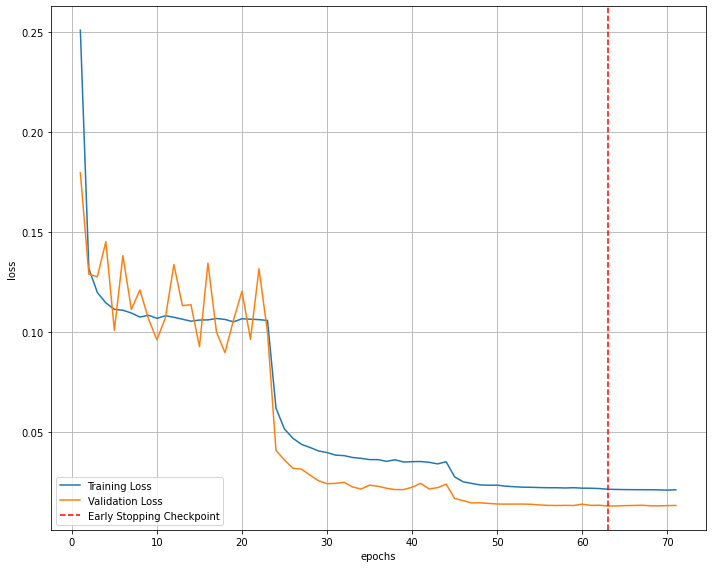

NameError: name 'layer' is not defined

In [27]:
from itertools import product
train_acc = []
valid_acc = []
for lr, keep_prob, weight_decay in product(lrs, keep_probs, weight_decays) :
    # graph, model이 저장될 path
    path = 'HyperParams-{}_{}_{}'.format(lr, keep_prob, weight_decay)
    model, opt, scheduler = get_model(lr = lr, keep_prob = keep_prob, xavier = xavier, weight_decay = weight_decay)
    
    model, train_loss, valid_loss = fit(epochs, model, loss_func, opt, scheduler, train_dl, valid_dl, path = path)
    loss_graph(train_loss, valid_loss)
    print('lr : {}, keep_prob : {}, weight_decay : {} Score'.format(lr, keep_prob, weight_decay))
    train_acc.append(accuracy(train_dl).item())
    valid_acc.append(accuracy(valid_dl).item())
    clear_gpu()
    print('==='*30)
    print('==='*30)


In [71]:
model = MyModule().to("cpu")
model.load_state_dict(torch.load('./model_AUG/HyperParams-0.001_0.85_0.005_checkpoint.pt'))

<All keys matched successfully>

In [72]:
model.eval()

MyModule(
  (layer1): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (layer2): Sequential(
    (0): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, c

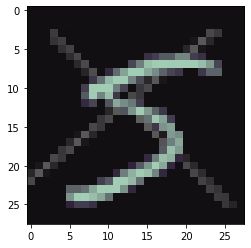

5
tensor([[-0.6969, -0.6784, -0.7153, -0.4564, -0.7171,  5.9800, -0.5547, -0.7073,
         -0.7035, -0.7178]], grad_fn=<AddmmBackward0>)
tensor([0.6353, 0.8000, 0.7059])


/home/krex/anaconda3/envs/krex_3.9/lib/python3.9/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


In [73]:
i = 5
print_image(X_test[i])
print(y_test[i])
a = torch.Tensor(X_test[i]).reshape(-1,28,28,3)
print(model(torch.Tensor(a)))
print(a[0,10,10,:])

In [74]:
from torch.utils.data import Dataset, DataLoader
import os
class ImageDataset(Dataset):
    """ Image shape: 28x28x3 """

    def __init__(self, root_dir, fmt=':06d', extension='.png'):
        self.root_dir = root_dir
        self.fmtstr = '{' + fmt + '}' + extension

    def __len__(self):
        return len(os.listdir(self.root_dir))

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.fmtstr.format(idx)
        img_path = os.path.join(self.root_dir, img_name)
        img = plt.imread(img_path)
        data = torch.from_numpy(img)
        return data
    
    


In [75]:
test_data = ImageDataset('../dataset/test_img/')



In [76]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1)

In [77]:
# for x in test_loader:
#   print_image(x.reshape(28,28,3))

In [78]:
def inference(data_loader, model):
    """ model inference """

    model.eval()
    preds = []

    with torch.no_grad():
        for X in data_loader:
            y_hat = model(X)
            # print(y_hat.shape)
            y_hat.argmax()
            # print(y_hat)
            _, predicted = torch.max(y_hat, 1)
            # print(predicted)
            preds.extend(map(lambda t: t.item(), predicted))
            # print(len(preds))

    return preds

In [79]:
preds = inference(test_loader, model)
true = [7,2,1,0,4,1,4,9,5,9,0,6,9,0,1,5,9,7,3,4,9,6,6,5,4,0,7,4]
print(preds)

[7, 3, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4]


In [80]:
from sklearn.metrics import accuracy_score
accuracy_score(true, preds)

0.9642857142857143

In [81]:
np.where(np.array(preds)!=np.array(true))

(array([1]),)

In [83]:
model.eval()

MyModule(
  (layer1): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (layer2): Sequential(
    (0): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, c

In [139]:
def inf(data_loader, model):
    """ model inference """

    model.eval()
    preds = []
    y_list =[]
    with torch.no_grad():
        for x,y in data_loader:
            x = x
            y_hat = model(x)
            # print(y_hat.shape)
            y_hat.argmax()
            # print(y_hat)
            _, predicted = torch.max(y_hat, 1)
            # print(predicted)
            preds.extend(map(lambda t: t.item(), predicted))
            y_list.extend(y.cpu())
            # print(len(preds))

    return preds, y_list

In [140]:
model = MyModule().to("cuda:0")
model.load_state_dict(torch.load('./model_AUG/HyperParams-0.001_0.85_0.005_checkpoint.pt'))

<All keys matched successfully>

In [141]:
preds ,y = inf(valid_dl,model)

/home/krex/anaconda3/envs/krex_3.9/lib/python3.9/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


In [142]:
len(y)

15000

In [143]:
len(preds)

15000

In [144]:
from sklearn.metrics import accuracy_score
accuracy_score(y, preds)

0.9998666666666667